In [1]:
%gui qt

In [2]:
import sys
sys.path.insert(0,'/home/georgeos/Documents/GitHub/SYMPTOMM2')
from SYMPTOMM.cell import Cell
from SYMPTOMM.scene_functions import create_space, step_and_update
from SYMPTOMM.trench_geometry import trench_creator
from SYMPTOMM.phase_contrast_drawing import *
import napari
import tifffile
import numpy as np
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean

div_odd = lambda n: (n//2, n//2 + 1)


real_image = tifffile.imread("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/trench_{}/T_{}.tif".format(
    str(np.random.randint(1,56)).zfill(2),
    str(np.random.randint(20,25)).zfill(3)))



viewer = napari.view_image(real_image, colormap='Greys_r')
background_label = viewer.add_labels(np.zeros(real_image.shape), name = "background")
cell_label = viewer.add_labels(np.zeros(real_image.shape), name = "cell")
trench_label = viewer.add_labels(np.zeros(real_image.shape), name = "trench")

/home/georgeos/anaconda3/envs/SYMPTOMM/lib/python3.9/site-packages/napari/layers/labels/labels.py:382: UserWarning: Float dtypes are not supported for Labels layers. Converting data to integers...
  warnings.warn(
/home/georgeos/anaconda3/envs/SYMPTOMM/lib/python3.9/site-packages/napari/layers/labels/labels.py:382: UserWarning: Float dtypes are not supported for Labels layers. Converting data to integers...
  warnings.warn(
/home/georgeos/anaconda3/envs/SYMPTOMM/lib/python3.9/site-packages/napari/layers/labels/labels.py:382: UserWarning: Float dtypes are not supported for Labels layers. Converting data to integers...
  warnings.warn(


In [3]:
def run_simulation(trench_length, trench_width, cell_max_length, cell_width):
    space = create_space()
    space.gravity = 0, -0.3
    dt = 1/100


    pix_mic_conv = 10 # pixels per micron
    scale_factor = 3 * pix_mic_conv

    trench_length = trench_length*scale_factor
    trench_width = trench_width*scale_factor
    trench_creator(trench_width,trench_length,(35,0),space) # Coordinates of bottom left corner of the trench
    #trench_creator(35,trench_length,(35*3,0),space) # Coordinates of bottom left corner of the trench
    #trench_creator(35,trench_length,(35*5,0),space) # Coordinates of bottom left corner of the trench

    cell1 = Cell(
        length = cell_max_length*scale_factor,  
        width = cell_width*scale_factor, 
        resolution = 60, 
        position = (20+35,40), 
        angle = 0.8, 
        space = space,
        dt = 1/60,
        growth_rate_constant = 1,
        max_length = cell_max_length*scale_factor,
        max_length_mean =cell_max_length*scale_factor,
        max_length_var = 0.1*np.sqrt(scale_factor),
        width_var = 0.03*np.sqrt(scale_factor),
        width_mean = cell_width*scale_factor
    )


    cells = [cell1]
    cell_timeseries = []
    phys_iters = 200
    for x in range(300):
        cells = step_and_update(dt=dt, cells=cells, space=space, phys_iters=phys_iters,ylim=trench_length)
        if x > 250:
            cell_timeseries.append(deepcopy(cells))
    return cell_timeseries, space


condensers = get_condensers()
W, R, diameter = condensers["Ph2"]
scale = 0.108379937 / 3 #0.35 #micron per pixel
min_sigma = 0.42*0.6/2 / scale # micron
#kernel= get_phase_contrast_kernel(R, W, 50, scale, 5, 15, 0.6)
#scalebar = ScaleBar(scale, 'um')
#plt.figure(figsize=(5.1,5.1))
#plt.gca().add_artist(scalebar)
#plt.imshow(kernel,cmap="Greys_r")
#plt.axis("off")
#plt.title("Phase Contrast")
#plt.show()
#kernel = cp.array(kernel)
#kernel_np = kernel.get()
#plt.figure(figsize = (15,10))
#plt.plot(np.arange(-50,51)*scale,kernel_np[50,:])
#plt.show()

In [4]:
cell_timeseries, space = run_simulation(trench_length=14.9, trench_width=1.4, cell_max_length=5.5, cell_width=0.9)
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=14)(delayed(gen_cell_props_for_draw)(a, ID_props) for a in cell_timeseries[-15:-1])
do_transformation = True
offset = 80
scenes = Parallel(n_jobs=14)(delayed(draw_scene)(cell_properties, do_transformation) for cell_properties in tqdm(cell_timeseries_properties))
#OPL_scenes = [generate_PC_OPL(main_segments, offset, scene[0], trench_multiplier,cell_multiplier,background_multiplier) for scene in scenes]
#OPL_scenes_convolved = np.array([convolve_rescale(OPL_scene,kernel,1) for OPL_scene in OPL_scenes])

100%|██████████| 14/14 [00:00<00:00, 9583.85it/s]


In [5]:
#make convolved image and real image same shape
def make_images_same_shape(real_image,synthetic_image, rescale = True):
    x_diff = synthetic_image.shape[1] - real_image.shape[1]
    remove_from_left, remove_from_right = div_odd(x_diff)
    y_diff = synthetic_image.shape[0] - real_image.shape[0]
    if y_diff > 0:
        synthetic_image = synthetic_image[y_diff:,remove_from_left-1:-remove_from_right]
    else:
        synthetic_image = synthetic_image[:,remove_from_left-1:-remove_from_right]
        real_image = real_image[abs(y_diff):,:]

    if rescale:
        real_image = rescale_intensity(real_image, out_range=np.float32)
        synthetic_image = rescale_intensity(synthetic_image, out_range=np.float32)
    return real_image, synthetic_image

In [6]:
def get_similarity_metrics(real_image,synthetic_image):
    synthetic_image = match_histograms(synthetic_image, real_image, multichannel=False)
    synthetic_image = resize(synthetic_image,real_image.shape,clip=False,preserve_range=False,anti_aliasing=None)
    synthetic_image = synthetic_image/np.max(synthetic_image)
    ssim_real = ssim(synthetic_image, real_image)
    intersection = return_intersection_between_image_hists(synthetic_image, real_image, 100)
    #sims 
    synthetic_image_ = deepcopy(synthetic_image)
    synthetic_image_.shape += (1,)
    
    real_image_ = deepcopy(real_image)
    real_image_.shape += (1,)
    _fsim = fsim(synthetic_image_,real_image_)
    _issm = issm(synthetic_image_,real_image_)
    _sam = sam(synthetic_image_,real_image_)
    _sre = sre(synthetic_image_,real_image_)
    objs = [ssim_real, 0.5*intersection, _fsim, _issm, _sam, _sre/20]
    return objs

In [50]:
def generate_PC_OPL(main_segments, offset, scene, mask, trench_multiplier,cell_multiplier,background_multiplier):
    def get_OPL_image():
        segment_1_top_left = (0 + offset, int(main_segments.iloc[0]["bb"][0] + offset))
        segment_1_bottom_right = (int(main_segments.iloc[0]["bb"][3] + offset), int(main_segments.iloc[0]["bb"][2] + offset))

        segment_2_top_left = (0 + offset, int(main_segments.iloc[1]["bb"][0] + offset))
        segment_2_bottom_right = (int(main_segments.iloc[1]["bb"][3] + offset), int(main_segments.iloc[1]["bb"][2] + offset))

        test_scene = np.zeros(scene.shape) + background_multiplier
        rr, cc = draw.rectangle(start = segment_1_top_left, end = segment_1_bottom_right, shape = test_scene.shape)
        test_scene[rr,cc] = 1 * trench_multiplier
        rr, cc = draw.rectangle(start = segment_2_top_left, end = segment_2_bottom_right, shape = test_scene.shape)
        test_scene[rr,cc] = 1 * trench_multiplier
        circ_midpoint_y = (segment_1_top_left[1] + segment_2_bottom_right[1])/2
        radius = (segment_1_top_left[1] - offset - (segment_2_bottom_right[1] - offset))/2
        circ_midpoint_x = (offset) + radius

        rr, cc = draw.rectangle(start = segment_2_top_left, end = (circ_midpoint_x,segment_1_top_left[1]), shape = test_scene.shape)
        test_scene[rr.astype(int),cc.astype(int)] = 1 * trench_multiplier
        rr, cc = draw.disk(center = (circ_midpoint_x, circ_midpoint_y), radius = radius, shape = test_scene.shape)
        rr_semi = rr[rr < (circ_midpoint_x + 1)]
        cc_semi = cc[rr < (circ_midpoint_x + 1)]
        test_scene[rr_semi,cc_semi] = background_multiplier
        no_cells = deepcopy(test_scene)
        test_scene += scene * cell_multiplier
        test_scene = test_scene[segment_2_top_left[0]:segment_1_bottom_right[0],segment_2_top_left[1]:segment_1_bottom_right[1]]
        mask_resized = mask[segment_2_top_left[0]:segment_1_bottom_right[0],segment_2_top_left[1]:segment_1_bottom_right[1]]
        
        no_cells = no_cells[segment_2_top_left[0]:segment_1_bottom_right[0],segment_2_top_left[1]:segment_1_bottom_right[1]]
        expanded_scene_no_cells = np.zeros((int(no_cells.shape[0]*1.2), no_cells.shape[1]*2)) + trench_multiplier
        expanded_scene_no_cells[expanded_scene_no_cells.shape[0] - no_cells.shape[0]:,int(no_cells.shape[1]/2):int(no_cells.shape[1]/2) + no_cells.shape[1]] = no_cells

        expanded_scene = np.zeros((int(test_scene.shape[0]*1.2), test_scene.shape[1]*2)) + trench_multiplier
        expanded_scene[expanded_scene.shape[0] - test_scene.shape[0]:,int(test_scene.shape[1]/2):int(test_scene.shape[1]/2) + test_scene.shape[1]] = test_scene
        
        expanded_mask = np.zeros((int(test_scene.shape[0]*1.2), test_scene.shape[1]*2))
        expanded_mask[expanded_mask.shape[0] - test_scene.shape[0]:,int(test_scene.shape[1]/2):int(test_scene.shape[1]/2) + test_scene.shape[1]] = mask_resized
        
        return expanded_scene, expanded_scene_no_cells, expanded_mask
    expanded_scene, expanded_scene_no_cells, expanded_mask = get_OPL_image()
    if expanded_scene is None:
        main_segments = main_segments.reindex(index=main_segments.index[::-1])
        expanded_scene, expanded_scene_no_cells, expanded_mask = get_OPL_image()
    return expanded_scene, expanded_scene_no_cells, expanded_mask


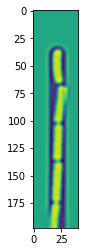

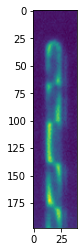

In [111]:
trench_multiplier=5
cell_multiplier=0.3
background_multiplier=0.3


expanded_scene, expanded_scene_no_cells, expanded_mask = generate_PC_OPL(
    main_segments=main_segments,
    offset=50,
    scene = scenes[0][0],
    mask = scenes[0][1],
    trench_multiplier=trench_multiplier,
    cell_multiplier=cell_multiplier,
    background_multiplier=background_multiplier
)


resize_amount = 1/scale/10

## Creating the synthetic image
kernel = get_phase_contrast_kernel(R, W, 50, scale, 5, 6, 0.6)
convolved = convolve_rescale(expanded_scene, kernel, resize_amount)
real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale=True)

## getting the cell mask to the right shape
expanded_mask_resized = rescale(expanded_mask,1/resize_amount, anti_aliasing=False)
real_resize, expanded_mask_resized_reshaped = make_images_same_shape(real_image,expanded_mask_resized, rescale=True)


## Getting the trench mask to the right shape


plt.imshow(expanded_resized)
plt.show()
plt.imshow(real_resize)
plt.show()

In [209]:
def get_images_to_optimise(expanded_scene,expanded_scene_no_cells, real_image, convolved, resize_amount):
    expanded_trench_mask = rescale(expanded_scene_no_cells == trench_multiplier, 1/resize_amount, anti_aliasing=False)
    real_resize, expanded_trench_mask = make_images_same_shape(real_image,expanded_trench_mask, rescale=True)
    just_trench = expanded_trench_mask * expanded_resized
    
    expanded_cell_pseudo_mask = (expanded_scene - expanded_scene_no_cells).astype(bool)
    expanded_cell_pseudo_mask = rescale(expanded_cell_pseudo_mask, 1/resize_amount, anti_aliasing=False)

    real_resize, expanded_cell_pseudo_mask = make_images_same_shape(real_image,expanded_cell_pseudo_mask, rescale=True)
    just_cells = expanded_cell_pseudo_mask * expanded_resized
    
    expanded_background_mask = (expanded_scene_no_cells == background_multiplier) ^ (expanded_scene - expanded_scene_no_cells).astype(bool)
    expanded_background_mask = rescale(expanded_background_mask, 1/resize_amount, anti_aliasing=False)
    real_resize, expanded_background_mask = make_images_same_shape(real_image,expanded_background_mask, rescale=True)
    just_background = expanded_background_mask * expanded_resized
    
    return just_trench, just_cells, just_background

In [225]:
just_trench, just_cells, just_background = get_images_to_optimise(expanded_scene,expanded_scene_no_cells, real_image, convolved, resize_amount)

In [ ]:
progress = []
def callbackF(x, f, context):
    print(x)
    progress.append(x)
    
def callbackSHGo(x):
    print(x)
    progress.append(x)

In [ ]:
bounds = list(zip([min_sigma, 1.0, 0.2, 1, 14, 1.0, 3, 0.8], [20.0, 30.0, 5.0, 20.0, 17, 1.8, 6, 1.1]))

In [ ]:
ret = shgo(objective_function, bounds = np.array(bounds),callback=callbackSHGo,options={"minimize_every_iter":True})
#ret = dual_annealing(objective_function, bounds = np.array(bounds),callback=callbackF,maxiter=1000,initial_temp=5*10**4)

In [ ]:
ret.x

In [ ]:
optimal_images = objective_function(ret.x, True)

In [ ]:
plt.imshow(optimal_images[1][0],cmap="Greys_r")

In [ ]:
optimal_images[1]